<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/DPHI_COVID_Densenet201_91_45.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1BFc2Lt2N1swO8BKRvLMEyUhLzF52RFvr',
dest_path='content/covid_image_data.zip',
unzip=True)

Unzipping...Done.


In [2]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
labels = pd.read_csv("/content/content/covid_image_data/Training_set_covid.csv")

labels.head() 
file_paths = [[fname, '/content/content/covid_image_data/train/' + fname] for fname in labels['filename']]

if len(labels) == len(file_paths):
  print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
  print('Number of labels does not match the number of filenames')

images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()


train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

Number of labels i.e.  3479 matches the number of filenames i.e.  3479


,filename,filepaths,label
0,Image_1.jpg,/content/content/covid_image_data/train/Image_...,1
1,Image_2.jpg,/content/content/covid_image_data/train/Image_...,0
2,Image_3.jpg,/content/content/covid_image_data/train/Image_...,0
3,Image_4.jpg,/content/content/covid_image_data/train/Image_...,0
4,Image_5.jpg,/content/content/covid_image_data/train/Image_...,0


In [4]:
test_image_order = pd.read_csv("/content/content/covid_image_data/Testing_set_covid.csv")
test_image_order.head()

file_paths_test = [[fname, '/content/content/covid_image_data/test/' + fname] for fname in test_image_order['filename']]

test_images = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])
test_images.head()


,filename,filepaths
0,Image_1.jpg,/content/content/covid_image_data/test/Image_1...
1,Image_2.jpg,/content/content/covid_image_data/test/Image_2...
2,Image_3.jpg,/content/content/covid_image_data/test/Image_3...
3,Image_4.jpg,/content/content/covid_image_data/test/Image_4...
4,Image_5.jpg,/content/content/covid_image_data/test/Image_5...


In [5]:
data = [] 
image_size = 224 
test_pixel_data = []

for i in range(len(train_data)):

  img_array = cv2.imread(train_data['filepaths'][i], cv2.COLOR_BGR2RGB) 

  new_img_array = cv2.resize(img_array, (image_size, image_size))
  #new_img_array = cv2.GaussianBlur(new_img_array,(5,5),0)
  data.append([new_img_array, train_data['label'][i]])


for i in range(len(test_images)):

  img_array = cv2.imread(test_images['filepaths'][i], cv2.COLOR_BGR2RGB) 

  new_img_array = cv2.resize(img_array, (image_size, image_size))
  #new_img_array = cv2.GaussianBlur(new_img_array,(5,5),0)
  test_pixel_data.append(new_img_array)

In [6]:
print(len(data),len(test_pixel_data))

3479 870


In [7]:
np.random.shuffle(data)

In [8]:
x = []
y = []

counter = 406

for image in data:
  # if image[1] == 0 and counter >= 0:
  #   x.append(image[0])
  #   y.append(image[1])
  #   counter -= 1

  # elif image[1] == 1:
  #   x.append(image[0])
  #   y.append(image[1])


  x.append(image[0])
  y.append(image[1])

# converting x & y to numpy array as they are list
x = np.array(x)
y = np.array(y)

In [9]:
np.unique(y, return_counts=True)

(array([0, 1]), array([3073,  406]))

In [ ]:
 pd.Series(y).value_counts()

0    3073
1     406
dtype: int64

In [11]:
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state = 42,stratify=y)

In [12]:
test_pixel_data = np.array(test_pixel_data)

test_pixel_data = test_pixel_data/255

print(X_train.shape,X_val.shape,test_pixel_data.shape)

(2783, 224, 224, 3) (696, 224, 224, 3) (870, 224, 224, 3)


In [13]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow(X_train,y_train,batch_size=32)

val_generator = val_datagen.flow(X_val,y_val,batch_size=32)

In [14]:
pd.Series(y_val).value_counts(normalize=True)

0    0.883621
1    0.116379
dtype: float64

In [15]:
pd.Series(y_train).value_counts(normalize=True)

0    0.88322
1    0.11678
dtype: float64

In [16]:
print(X_train.shape,X_val.shape)

(2783, 224, 224, 3) (696, 224, 224, 3)


In [17]:
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [18]:
cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1, mode='auto')]

# lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_loss",
#     factor=0.1,
#     patience=2,
#     verbose=0,
#     mode="auto",
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=0.00001,
# )

In [19]:
from keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201
from keras.layers import *
from keras.models import Sequential
from keras.regularizers import *
from keras.optimizers import Adam

**This is the densenet architecture that scores a F1 Score of 91.4572864321608 on submission. Here I have reduced the number of dense layer or fully connected layer and it improved the scores from 88.55721393034825 in case of 3 fully connected layer to 91.4572864321608**

In [39]:
def build_model():
    model = Sequential()
    
    conv_base = DenseNet201(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
    model.add(conv_base)
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    # model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    # model.add(BatchNormalization())
    # model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    # model.add(BatchNormalization())
    # model.add(Dense(1024, activation='relu', kernel_regularizer=l1_l2(0.01)))
    # model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    for layer in model.layers:
      layer.trainable = True
    #train_layers = [layer for layer in conv_base.layers[::-1][:5]]
    """
    for layer in conv_base.layers:
      if layer in train_layers:
        layer.trainable = True
    """
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy',get_f1])
    
    return model



In [40]:
model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
batch_normalization_3 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049      
Total params: 22,274,113
Trainable params: 22,037,121
Non-trainable params: 236,992
_________________________________________________________________


In [41]:
model.fit(train_generator,steps_per_epoch=87,epochs=100,validation_data=val_generator,validation_steps=22,callbacks=[cbs],class_weight={0:1,1:2})

#model.fit(train_generator,steps_per_epoch=21,epochs=50,validation_data=val_generator,validation_steps=6,callbacks=[es])

Epoch 1/100
87/87 [==============================] - 51s 591ms/step - loss: 628.4645 - accuracy: 0.7492 - get_f1: 0.4643 - val_loss: 481.3228 - val_accuracy: 0.2141 - val_get_f1: 0.2211
Epoch 2/100
87/87 [==============================] - 50s 577ms/step - loss: 361.3675 - accuracy: 0.8983 - get_f1: 0.6859 - val_loss: 253.7653 - val_accuracy: 0.1480 - val_get_f1: 0.2078
Epoch 3/100
87/87 [==============================] - 50s 572ms/step - loss: 170.8621 - accuracy: 0.9457 - get_f1: 0.7992 - val_loss: 100.9907 - val_accuracy: 0.5014 - val_get_f1: 0.3036
Epoch 4/100
87/87 [==============================] - 50s 572ms/step - loss: 55.3404 - accuracy: 0.9501 - get_f1: 0.8058 - val_loss: 21.8934 - val_accuracy: 0.8017 - val_get_f1: 0.5024
Epoch 5/100
87/87 [==============================] - 50s 574ms/step - loss: 10.4025 - accuracy: 0.9188 - get_f1: 0.7223 - val_loss: 4.7571 - val_accuracy: 0.9267 - val_get_f1: 0.5810
Epoch 6/100
87/87 [==============================] - 50s 573ms/step - loss:

In [42]:
preds =  model.predict(X_val/255.0)
predictions = []
for i in preds:
  if i[0] > 0.5:
    predictions.append(1)
  else:
    predictions.append(0)

In [43]:
from sklearn.metrics import f1_score
f1_score(y_val,predictions)

0.8461538461538461

**Final Predictions**

In [44]:
preds = model.predict(test_pixel_data)


In [45]:
predictions = []
for i in preds:
  if i[0] > 0.5:
    predictions.append(1)
  else:
    predictions.append(0)

In [46]:
result = pd.DataFrame(predictions,columns=['prediction'])

result.value_counts()

prediction
0             773
1              97
dtype: int64

In [47]:
result.to_csv('denseNet201_last_five2.csv',index=False)

#### **Dphi Scores:91.4572864321608**

#### **ResNet101 - Experiment**

*****************************************************************************************

In [63]:
from tensorflow.keras.applications import ResNet50

In [64]:
def build_model():
    model = Sequential()
    
    conv_base = ResNet50(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
    model.add(conv_base)
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    # model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    # model.add(BatchNormalization())
    # model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    # model.add(BatchNormalization())
    # model.add(Dense(1024, activation='relu', kernel_regularizer=l1_l2(0.01)))
    # model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    for layer in model.layers:
      layer.trainable = True
    #train_layers = [layer for layer in conv_base.layers[::-1][:5]]
    """
    for layer in conv_base.layers:
      if layer in train_layers:
        layer.trainable = True
    """
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy',get_f1])
    
    return model



In [65]:
model = build_model()
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
batch_normalization_11 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_11 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_12 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 2049      
Total params: 27,802,497
Trainable params: 27,741,185
Non-trainable params: 61,312
_________________________________________________________________


In [ ]:
history = model.fit(train_generator,steps_per_epoch=87,epochs=100,validation_data=val_generator,validation_steps=22,callbacks=[cbs],class_weight={0:1,1:2})

Epoch 1/100
87/87 [==============================] - 34s 388ms/step - loss: 657.4337 - accuracy: 0.7700 - get_f1: 0.4825 - val_loss: 501.9218 - val_accuracy: 0.1164 - val_get_f1: 0.2037
Epoch 2/100
87/87 [==============================] - 33s 375ms/step - loss: 374.3963 - accuracy: 0.9296 - get_f1: 0.7572 - val_loss: 259.7125 - val_accuracy: 0.8836 - val_get_f1: 0.0000e+00
Epoch 3/100
87/87 [==============================] - 32s 368ms/step - loss: 174.3942 - accuracy: 0.9404 - get_f1: 0.7888 - val_loss: 101.4267 - val_accuracy: 0.8836 - val_get_f1: 0.0000e+00
Epoch 4/100
87/87 [==============================] - 32s 371ms/step - loss: 55.7646 - accuracy: 0.9303 - get_f1: 0.7531 - val_loss: 31.1268 - val_accuracy: 0.1164 - val_get_f1: 0.2043
Epoch 5/100
87/87 [==============================] - 32s 371ms/step - loss: 11.0309 - accuracy: 0.9249 - get_f1: 0.7218 - val_loss: 4.7662 - val_accuracy: 0.8836 - val_get_f1: 0.0000e+00
Epoch 6/100
87/87 [==============================] - 32s 370ms/

#### **Grad-CAM**

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2

#### **Function to display images**

In [ ]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

##**Arguement Parser**

********************************************

####**DenseNet169**

******************************************************************************

In [49]:
from tensorflow.keras.applications import DenseNet169

In [56]:
def build_model():
    model = Sequential()
    
    conv_base = DenseNet169(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
    model.add(conv_base)
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    # model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    # model.add(BatchNormalization())
    # model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    # model.add(BatchNormalization())
    # model.add(Dense(1024, activation='relu', kernel_regularizer=l1_l2(0.01)))
    # model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    for layer in model.layers:
      layer.trainable = True
    #train_layers = [layer for layer in conv_base.layers[::-1][:5]]
    """
    for layer in conv_base.layers:
      if layer in train_layers:
        layer.trainable = True
    """
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy',get_f1])
    
    return model


In [57]:
model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
batch_normalization_9 (Batch (None, 1664)              6656      
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              3409920   
_________________________________________________________________
batch_normalization_10 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2049      
Total params: 16,069,697
Trainable params: 15,903,873
Non-trainable params: 165,824
_________________________________________________________________


In [58]:
history = model.fit(train_generator,steps_per_epoch=87,epochs=100,validation_data=val_generator,validation_steps=22,callbacks=[cbs],class_weight={0:1,1:2})

Epoch 1/100
87/87 [==============================] - 39s 445ms/step - loss: 569.1625 - accuracy: 0.7183 - get_f1: 0.4213 - val_loss: 441.0738 - val_accuracy: 0.6710 - val_get_f1: 0.3286
Epoch 2/100
87/87 [==============================] - 37s 429ms/step - loss: 336.5071 - accuracy: 0.8875 - get_f1: 0.6592 - val_loss: 241.0844 - val_accuracy: 0.3621 - val_get_f1: 0.2622
Epoch 3/100
87/87 [==============================] - 38s 434ms/step - loss: 167.0620 - accuracy: 0.9486 - get_f1: 0.8030 - val_loss: 102.9701 - val_accuracy: 0.6293 - val_get_f1: 0.3616
Epoch 4/100
87/87 [==============================] - 38s 440ms/step - loss: 59.4338 - accuracy: 0.9508 - get_f1: 0.7994 - val_loss: 25.8306 - val_accuracy: 0.8678 - val_get_f1: 0.6101
Epoch 5/100
87/87 [==============================] - 38s 441ms/step - loss: 13.1050 - accuracy: 0.8987 - get_f1: 0.6801 - val_loss: 20.6674 - val_accuracy: 0.5330 - val_get_f1: 0.3263
Epoch 6/100
87/87 [==============================] - 39s 445ms/step - loss

******************************************************************************

#### **Evaluation of the model**

In [59]:
preds =  model.predict(X_val/255.0)
predictions = []
for i in preds:
  if i[0] > 0.5:
    predictions.append(1)
  else:
    predictions.append(0)

#
from sklearn.metrics import f1_score
f1_score(y_val,predictions)

0.8727272727272727

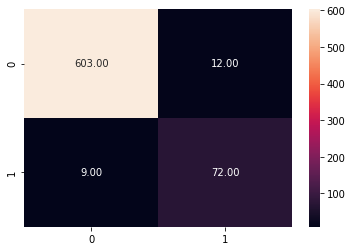

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val,predictions),annot=True,fmt=".2f")

#### **Predict on the resultset**

In [61]:
preds = model.predict(test_pixel_data)
#
predictions = []
for i in preds:
  if i[0] > 0.5:
    predictions.append(1)
  else:
    predictions.append(0)
#
result = pd.DataFrame(predictions,columns=['prediction'])
#
result.value_counts()
#
result.to_csv('denseNet169_full_trained.csv',index=False)

In [62]:
result.value_counts()

prediction
0             758
1             112
dtype: int64

#### **Dphi Scores :86.91588785046729 for Densenet169**